# Future - Determing Optimal Bidding Strategies

Utilizing our models for rank, clicks, and policies sold, we can determine which bidding strategy to apply separately to each customer demographic to minimize total cost while constraining the minimum number of policies sold.

Unfortunately, due to the limitations of our original data, we do not have the capability to encorporate a change in bidding price into our models. This limits our capabilities to predict how exact changes in the bid number (change from \\$10 to \\$15) affects rank, click, or policies sold.

We can only assume two resonable strategies we can consider: Original \\$10 Bid or a Minimum \\$1 Bid. The idea is a \\$1 bid will gurantee all ads will be placed in Rank 5 while the \\$ 10 bid will follow our original models. We will pick between one of these two models for each demographic in order to minimize the cost while maintaing the necessary 400 policies sold per 10,000 customers

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import *

#Read in Probabilities of Ranks, Clicks, Policies Sold from our Models
rank_proba_df = pd.read_pickle("rank_proba_df.pkl")
click_policies_proba_df = pd.read_pickle("click_policies_proba.pkl")

#Remove maximum display limits on columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#
dist_of_cust_at_rank = []
for index, row in click_policies_proba_df.iterrows():
    temp = rank_proba_df[(rank_proba_df["Insured"] == click_policies_proba_df.iloc[index,0]) & 
                         (rank_proba_df["Num_Vehicles"] == click_policies_proba_df.iloc[index,1]) & 
                         (rank_proba_df["Num_Drivers"] == click_policies_proba_df.iloc[index,2])]
    dist_of_cust_at_rank.append(dict(temp.iloc[0])["Rank " + str(dict(row)["rank"]) + " Prob"])

#
all_data = click_policies_proba_df.copy()
all_data["policies_sold_per_click"] = all_data["policies_sold"] / all_data["click"]
all_data["rank_dist"] = dist_of_cust_at_rank
all_data["Expected_Num_Cust"] = np.round(all_data["rank_dist"] * 300).astype(int)
all_data["total_bid_cost"] = all_data["Expected_Num_Cust"] * all_data["click"]* all_data["bid"]    
all_data["Expected_policies_sold"] = np.round(all_data["Expected_Num_Cust"] * all_data["policies_sold"]).astype(int)
all_data["Expected_cost_per_policies_sold"] = all_data["total_bid_cost"] / all_data["Expected_policies_sold"]

insured = ["unknown", "Y", "N"]
vehicles = [1, 2, 3]
drivers = [1, 2]
marry = ["M", "S"]
bid = [10]
rank = [1,2,3,4,5]
pre_df = []
for x in insured:
    for y in vehicles:
        for z in drivers:
            for u in marry:
                temp = {}
                temp["Currently Insured"] = x
                temp["Number of Vehicles"] = y
                temp["Number of Drivers"] = z
                temp["Marital Status"] = u
                temp_df = all_data[(all_data["Currently Insured"] == x) & 
                                   (all_data["Number of Vehicles"] == y) & 
                                   (all_data["Number of Drivers"] == z) & 
                                   (all_data["Marital Status"] == u)]
                temp_df_rank = rank_proba_df[(rank_proba_df["Insured"] == x) & 
                                             (rank_proba_df["Num_Vehicles"] == y) & 
                                             (rank_proba_df["Num_Drivers"] == z)]
                temp["Expected Rank"] = float(temp_df_rank["Expected Rank"])
                temp["Expected Policies Sold"] = np.sum(temp_df["Expected_policies_sold"])
                temp["Current Weighted Click %"] = np.sum(temp_df["click"] * temp_df["Expected_Num_Cust"]) / np.sum(temp_df["Expected_Num_Cust"])
                temp["Cost"] = np.sum(temp_df["total_bid_cost"])
                temp["Cost per Policies Sold"] = temp["Cost"] / temp["Expected Policies Sold"]
                temp["Avg Policies Sold per Click"] = np.average(temp_df["policies_sold_per_click"])
                temp["Rank 5 - Expected Policies Sold"] = np.round(300 * temp_df.iloc[4,7]).astype(int)
                temp["Rank 5 - Cost"] = temp_df.iloc[4,6]*300
                temp["Rank 5 - Cost per Policies Sold"] = temp_df.iloc[4,6]*300 / np.round(300 * temp_df.iloc[4,7]).astype(int)
                pre_df.append(temp)
summary_df = pd.DataFrame(pre_df)

In [2]:
summary_df

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,Expected Rank,Expected Policies Sold,Current Weighted Click %,Cost,Cost per Policies Sold,Avg Policies Sold per Click,Rank 5 - Expected Policies Sold,Rank 5 - Cost,Rank 5 - Cost per Policies Sold
0,unknown,1,1,M,1.648584,60,0.401776,1205.326547,20.088776,0.549236,6,9.248891,1.541482
1,unknown,1,1,S,1.648584,66,0.401776,1205.326547,18.262523,0.596609,6,9.248891,1.541482
2,unknown,1,2,M,1.662524,51,0.400393,1201.178116,23.552512,0.458410,5,9.248891,1.849778
3,unknown,1,2,S,1.662524,55,0.400393,1201.178116,21.839602,0.498674,5,9.248891,1.849778
4,unknown,2,1,M,1.739222,48,0.372063,1116.189960,23.253958,0.463058,5,8.729410,1.745882
5,unknown,2,1,S,1.739222,52,0.372063,1116.189960,21.465192,0.503889,5,8.729410,1.745882
6,unknown,2,2,M,1.684354,42,0.382756,1144.440628,27.248586,0.385128,4,8.729410,2.182353
7,unknown,2,2,S,1.684354,45,0.382756,1144.440718,25.432016,0.419617,4,8.729410,2.182353
8,unknown,3,1,M,2.529486,26,0.238496,715.487313,27.518743,0.386756,4,8.441368,2.110342
9,unknown,3,1,S,2.529486,29,0.238496,715.487313,24.671976,0.421490,4,8.441368,2.110342


In [3]:
#Define empty arrays for expected policies sold and cost and strategy arrays
#Each row represents a demographic and column represents a strategy
#Here Column 0 is $1 Bid (Rank 5) Strategy and Column 1 is $10 Bid (Same) Strategy
Policies = np.zeros((36,2))
Cost = np.zeros((36,2))
xRank5 = np.zeros((36,2))
xsame = np.zeros((36,2))

#Setting strategy to binary 1 for Yes and 0 for No
xRank5[:,0] = 1
xsame[:,1] = 1

#Inputting values in Policies and Cost for different strategies
Policies[:,0]=summary_df["Rank 5 - Expected Policies Sold"]
Policies[:,1]=summary_df["Expected Policies Sold"]
Cost[:,0]=summary_df["Rank 5 - Cost"]
Cost[:,1]=summary_df["Cost"]

#Example with $10 Bid for all demographics
print("Utilizing the Same Bid of $10 for all Demographics")
print("Policies Sold:",np.sum(Policies*xsame))
print("Total Cost:",np.sum(Cost*xsame))
print("Cost per Policy Sold",np.sum(Cost*xsame)/np.sum(Policies*xsame))
print()

#Example with $1 Bid for all demographics
print("Utilizing the Minimum Bid of $1 to get Rank 5 for all Demographics")
print("Policies Sold:",np.sum(Policies*xRank5))
print("Total Cost:",np.sum(Cost*xRank5))
print("Cost per Policy Sold",np.sum(Cost*xRank5)/np.sum(Policies*xRank5))

Utilizing the Same Bid of $10 for all Demographics
Policies Sold: 838.0
Total Cost: 20747.463612556458
Cost per Policy Sold 24.758309800186705

Utilizing the Minimum Bid of $1 to get Rank 5 for all Demographics
Policies Sold: 139.0
Total Cost: 313.9344781637192
Cost per Policy Sold 2.2585214256382673


## Minimize Cost Using Two Known Strategies

Using these two possible strategies, we will look for the minimum cost that still has an expected 400 policies sold per 10000 customers.

In [6]:
#Defines counters for demographics and strategies
Demos = range(0,36)
Strats = range(0,2)

#Defines Linear Programming Problem with label and goal, minimization
Problem = LpProblem("Minimum_Cost_With_Policy_Constraint",LpMinimize).copy()

#Declares the LP variables - whether a model is on or off for a specific demographic
Variables = LpVariable.dicts("Vars",(Demos,Strats),cat="Binary")

#Defines the sum cost from our models and binary LP variables - no constraint so this will be minimized
Problem += lpSum([[Cost[i,j]*Variables[i][j] for j in Strats] for i in Demos])
    
#Defines the sum policies sold from our models and binary LP vairables - with constraint
Problem += lpSum([[Policies[i,j]*Variables[i][j] for j in Strats] for i in Demos]) >= 432

#Condition that ensures that only one strategy is picked per demographic
for i in Demos:
    Problem += lpSum([Variables[i][j] for j in Strats]) == 1

#Runs the LP solver and prints status    
status = Problem.solve()
print("Status:",LpStatus[Problem.status])

#Unwrap the optimal configuration from the solver into usable arrays for calculation and visualization
Final_Strategy_Per_Demo = np.zeros((36,2))
Final_Strategy_Per_Demo_Name = ['' for x in range(0,36)]
Demo_Name = ['Bid $1 - Rank 5','Bid $10 - Keep Same']
Demo_Name = ['Minimum Bid','Bid $10']
for v in Problem.variables() :
    if v.varValue > 0 :
        vsplit = v.name.split('_')
        i = int(vsplit[1])
        strat = int(vsplit[2])
        Final_Strategy_Per_Demo[i,strat] = 1        
        Final_Strategy_Per_Demo_Name[i] = Demo_Name[strat]
        
print("Minimizing Cost with at least 400 policies sold per 10,000")
print("Policies Sold:",np.sum(Policies*Final_Strategy_Per_Demo))
print("Total Cost:",np.sum(Cost*Final_Strategy_Per_Demo))
print("Cost per Policy Sold",np.sum(Cost*Final_Strategy_Per_Demo)/np.sum(Policies*Final_Strategy_Per_Demo))

Status: Optimal
Minimizing Cost with at least 400 policies sold per 10,000
Policies Sold: 434.0
Total Cost: 7199.948661625385
Cost per Policy Sold 16.589743459966325


In [9]:
Demo_With_Strategy = summary_df[summary_df.columns[0:4]].copy()
Demo_With_Strategy["Strategy"] = Final_Strategy_Per_Demo_Name
Demo_With_Strategy.sort_values(by = ["Strategy"])

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,Strategy
0,unknown,1,1,M,Bid $10
25,N,1,1,S,Bid $10
5,unknown,2,1,S,Bid $10
4,unknown,2,1,M,Bid $10
9,unknown,3,1,S,Bid $10
1,unknown,1,1,S,Bid $10
3,unknown,1,2,S,Bid $10
33,N,3,1,S,Minimum Bid
32,N,3,1,M,Minimum Bid
31,N,2,2,S,Minimum Bid


In [51]:
minCperP = 100000
optimal_policy = 0
Optimal_Strategy_Per_Demo = np.zeros((36,2))

Demos = range(0,36)
Strats = range(0,2)

for min_policy in range(432,800,5) :
    Problem = LpProblem("Minimum_Cost_With_Policy_Constraint",LpMinimize).copy()

    Variables = LpVariable.dicts("Vars",(Demos,Strats),cat="Binary")

    Problem += lpSum([[Cost[i,j]*Variables[i][j] for j in Strats] for i in Demos])
    
    Problem += lpSum([[Policies[i,j]*Variables[i][j] for j in Strats] for i in Demos]) >= min_policy

    for i in Demos:
        Problem += lpSum([Variables[i][j] for j in Strats]) == 1
    
    status = Problem.solve()
    #print("Status:",LpStatus[Problem.status])

    Final_Strategy_Per_Demo = np.zeros((36,2))
    Final_Strategy_Per_Demo_Name = ['' for x in range(0,36)]
    Demo_Name = ['Bid $1 - Rank 5','Bid $10 - Keep Same']
    for v in Problem.variables() :
        if v.varValue > 0 :
            vsplit = v.name.split('_')
            i = int(vsplit[1])
            strat = int(vsplit[2])
            Final_Strategy_Per_Demo[i,strat] = 1        
            Final_Strategy_Per_Demo_Name[i] = Demo_Name[strat]
            
    if np.sum(Cost*Final_Strategy_Per_Demo)/np.sum(Policies*Final_Strategy_Per_Demo) < minCperP :
        minCperP = np.sum(Cost*Final_Strategy_Per_Demo)/np.sum(Policies*Final_Strategy_Per_Demo)
        optimal_policy = min_policy
        Optimal_Strategy_Per_Demo = Final_Strategy_Per_Demo

print("Optimal Strategy which gurantees ",optimal_policy)        
print("Policies Sold:",np.sum(Policies*Optimal_Strategy_Per_Demo))
print("Total Cost:",np.sum(Cost*Optimal_Strategy_Per_Demo))
print("Cost per Policy Sold",np.sum(Cost*Optimal_Strategy_Per_Demo)/np.sum(Policies*Optimal_Strategy_Per_Demo))

Optimal Strategy which gurantees  437
Policies Sold: 440.0
Total Cost: 7266.715297996998
Cost per Policy Sold 16.515262040902268


# Mock Data - Scaling to Multiple Strategies

As proof of concept, we generate mock data based on 5 possible bidding strategies and their assumed effect on the rank distribution. The 5 strategies and their rank dependencies are:

1: Bid //$1 ->  All ads are placed in Rank 5
2: Bid //$5 -> Decrease the rank by one (when possible) from our model's rank distribution
3: Bid //$10 -> The rank distribution follows our model's rank distribution
4: Bid //$15 -> Increase the rank by one (when possible) from our model's rank distribution
5: Bid //$20 -> All ads are placed in Rank 1

Our linear programming solver can then determine which of the 5 strategies should be applied to each demographic to minimize cost. When our models are trained on varied bid data, we can use the exact rank distribution to determine the expected cost and sales. Then our solver can find exact bidding numbers for each demographic for the optimal bidding strategy.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rank_proba_df = pd.read_pickle("rank_proba_df.pkl")
click_policies_proba_df = pd.read_pickle("click_policies_proba.pkl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

dist_of_cust_at_rank = []
for index, row in click_policies_proba_df.iterrows():
    temp = rank_proba_df[(rank_proba_df["Insured"] == click_policies_proba_df.iloc[index,0]) & 
                         (rank_proba_df["Num_Vehicles"] == click_policies_proba_df.iloc[index,1]) & 
                         (rank_proba_df["Num_Drivers"] == click_policies_proba_df.iloc[index,2])]
    dist_of_cust_at_rank.append(dict(temp.iloc[0])["Rank " + str(dict(row)["rank"]) + " Prob"])
    
all_data = click_policies_proba_df.copy()
all_data["policies_sold_per_click"] = all_data["policies_sold"] / all_data["click"]
all_data["rank_dist"] = dist_of_cust_at_rank
all_data["Expected_Num_Cust"] = np.round(all_data["rank_dist"] * 300).astype(int)
all_data["total_bid_cost"] = all_data["Expected_Num_Cust"] * all_data["click"]* all_data["bid"]    
all_data["Expected_policies_sold"] = np.round(all_data["Expected_Num_Cust"] * all_data["policies_sold"]).astype(int)
all_data["Expected_cost_per_policies_sold"] = all_data["total_bid_cost"] / all_data["Expected_policies_sold"]
Increase_rank_policies = []
Decrease_rank_policies = []
Increase_rank_cost = []
Decrease_rank_cost = []
for index, row in all_data.iterrows():
    temp = dict(row)
    if temp["rank"] == 1:
        Increase_rank_policies.append((temp["policies_sold"])*temp["Expected_Num_Cust"])
        Increase_rank_cost.append(temp["Expected_Num_Cust"]*temp["click"]*15)    
        temp_below = dict(all_data.iloc[index + 1])
        Decrease_rank_policies.append((temp_below["policies_sold"])*temp["Expected_Num_Cust"])
        Decrease_rank_cost.append(temp["Expected_Num_Cust"]*temp_below["click"]*5)
    elif temp["rank"] == 5:
        Decrease_rank_policies.append((temp["policies_sold"])*temp["Expected_Num_Cust"])
        Decrease_rank_cost.append(temp["Expected_Num_Cust"]*temp["click"]*5)
        temp_above = dict(all_data.iloc[index - 1])
        Increase_rank_policies.append((temp_above["policies_sold"])*temp_above["Expected_Num_Cust"])
        Increase_rank_cost.append(temp["Expected_Num_Cust"]*temp_above["click"]*15)
    else:
        temp_above = dict(all_data.iloc[index - 1])
        temp_below = dict(all_data.iloc[index + 1])
        Increase_rank_policies.append((temp_above["policies_sold"])*temp["Expected_Num_Cust"])
        Decrease_rank_policies.append((temp_below["policies_sold"])*temp["Expected_Num_Cust"])
        Increase_rank_cost.append(15*temp_above["click"]*temp["Expected_Num_Cust"])
        Decrease_rank_cost.append(5*temp_below["click"]*temp["Expected_Num_Cust"])
all_data["Inc_rank_policies"] = np.round(Increase_rank_policies).astype(int)
all_data["Dec_rank_policies"] = np.round(Decrease_rank_policies).astype(int)
all_data["Inc_rank_cost"] = Increase_rank_cost
all_data["Dec_rank_cost"] = Decrease_rank_cost

insured = ["unknown", "Y", "N"]
vehicles = [1, 2, 3]
drivers = [1, 2]
marry = ["M", "S"]
bid = [10]
rank = [1,2,3,4,5]
pre_df = []
for x in insured:
    for y in vehicles:
        for z in drivers:
            for u in marry:
                temp = {}
                temp["Currently Insured"] = x
                temp["Number of Vehicles"] = y
                temp["Number of Drivers"] = z
                temp["Marital Status"] = u
                temp_df = all_data[(all_data["Currently Insured"] == x) & 
                                   (all_data["Number of Vehicles"] == y) & 
                                   (all_data["Number of Drivers"] == z) & 
                                   (all_data["Marital Status"] == u)]
                temp_df_rank = rank_proba_df[(rank_proba_df["Insured"] == x) & 
                                             (rank_proba_df["Num_Vehicles"] == y) & 
                                             (rank_proba_df["Num_Drivers"] == z)]
                temp["Expected Rank"] = float(temp_df_rank["Expected Rank"])
                temp["Expected Policies Sold"] = np.sum(temp_df["Expected_policies_sold"])
                temp["Current Weighted Click %"] = np.sum(temp_df["click"] * temp_df["Expected_Num_Cust"]) / np.sum(temp_df["Expected_Num_Cust"])
                temp["Cost"] = np.sum(temp_df["total_bid_cost"])
                temp["Cost per Policies Sold"] = temp["Cost"] / temp["Expected Policies Sold"]
                temp["Avg Policies Sold per Click"] = np.average(temp_df["policies_sold_per_click"])
                temp["Decrease Rank 1 - Expected Policies Sold"] = np.sum(temp_df["Dec_rank_policies"])
                temp["Decrease Rank 1 - Cost"] = np.sum(temp_df["Dec_rank_cost"])
                temp["Decrease Rank 1 - Cost per Policies Sold"] = temp["Decrease Rank 1 - Cost"] / temp["Decrease Rank 1 - Expected Policies Sold"]
                temp["Increase Rank 1 - Expected Policies Sold"] = np.sum(temp_df["Inc_rank_policies"])
                temp["Increase Rank 1 - Cost"] = np.sum(temp_df["Inc_rank_cost"])
                temp["Increase Rank 1 - Cost per Policies Sold"] = temp["Increase Rank 1 - Cost"] / temp["Increase Rank 1 - Expected Policies Sold"]
                temp["Rank 5 - Expected Policies Sold"] = np.round(300 * temp_df.iloc[4,7]).astype(int)
                temp["Rank 5 - Cost"] = temp_df.iloc[4,6]*300
                temp["Rank 5 - Cost per Policies Sold"] = temp_df.iloc[4,6]*300 / np.round(300 * temp_df.iloc[4,7]).astype(int)
                temp["Rank 1 - Expected Policies Sold"] = np.round(300 * temp_df.iloc[0,7]).astype(int)
                temp["Rank 1 - Cost"] = temp_df.iloc[0,6]*300*20
                temp["Rank 1 - Cost per Policies Sold"] = temp_df.iloc[0,6]*300 / np.round(300 * temp_df.iloc[0,7]).astype(int)
                pre_df.append(temp)
summary_df = pd.DataFrame(pre_df)

In [11]:
Policies = np.zeros((36,5))
Cost = np.zeros((36,5))
xRank5 = np.zeros((36,5))
xDec1 = np.zeros((36,5))
xsame = np.zeros((36,5))
xInc1 = np.zeros((36,5))
xRank1 = np.zeros((36,5))

xRank5[:,0] = 1
xDec1[:,1] = 1
xsame[:,2] = 1
xInc1[:,3] = 1
xRank1[:,4] = 1

Policies[:,0]=summary_df["Rank 5 - Expected Policies Sold"]
Policies[:,1]=summary_df["Decrease Rank 1 - Expected Policies Sold"]
Policies[:,2]=summary_df["Expected Policies Sold"]
Policies[:,3]=summary_df["Increase Rank 1 - Expected Policies Sold"]
Policies[:,4]=summary_df["Rank 1 - Expected Policies Sold"]

Cost[:,0]=summary_df["Rank 5 - Cost"]
Cost[:,1]=summary_df["Decrease Rank 1 - Cost"]
Cost[:,2]=summary_df["Cost"]
Cost[:,3]=summary_df["Increase Rank 1 - Cost"]
Cost[:,4]=summary_df["Rank 1 - Cost"]

### Minimize Cost with Policies Sold Constraint

In [21]:
minCperP = 100000
toy_optimal_policy = 0
Toy_Optimal_Strategy_Per_Demo = np.zeros((36,5))
Toy_Optimal_Strategy_Per_Demo_Name = ['' for x in range(0,36)]

Demos = range(0,36)
Strats = range(0,5)

for min_policy in range(1000,1001,5) :

    ToyModel = LpProblem("Minimum_Cost_Per_Policy",LpMinimize).copy()
    
    Variables_Toy = LpVariable.dicts("Vars",(Demos,Strats),cat="Binary")

    ToyModel += lpSum([[Cost[i,j]*Variables_Toy[i][j] for j in Strats] for i in Demos])
    
    ToyModel += lpSum([[Policies[i,j]*Variables_Toy[i][j] for j in Strats] for i in Demos]) >= min_policy
    
    for i in Demos:
        ToyModel += lpSum([Variables_Toy[i][j] for j in Strats]) == 1
    
    status = ToyModel.solve()
    #print("Status:",LpStatus[ToyModel.status])
    
    Final_Strategy_Per_Demo = np.zeros((36,5))
    Final_Strategy_Per_Demo_Name = ['' for x in range(0,36)]
    Demo_Name = ['Rank 5','Decrease 1 Rank','Keep Same','Increase 1 Rank','Rank 1']
    Demo_Name = ['Strategy 1','Strategy 2','Strategy 3','Strategy 4','Strategy 5']
    for v in ToyModel.variables() :
        if v.varValue > 0 :
            vsplit = v.name.split('_')
            i = int(vsplit[1])
            strat = int(vsplit[2])
            Final_Strategy_Per_Demo[i,strat] = 1        
            Final_Strategy_Per_Demo_Name[i] = Demo_Name[strat]
            
                
    if np.sum(Cost*Final_Strategy_Per_Demo)/np.sum(Policies*Final_Strategy_Per_Demo) < minCperP :
        minCperP = np.sum(Cost*Final_Strategy_Per_Demo)/np.sum(Policies*Final_Strategy_Per_Demo)
        toy_optimal_policy = min_policy
        Toy_Optimal_Strategy_Per_Demo = Final_Strategy_Per_Demo
        Toy_Optimal_Strategy_Per_Demo_Name = Final_Strategy_Per_Demo_Name

In [22]:
print("Optimal Strategy guarantees",toy_optimal_policy,"policies sold")
print("Policies Sold:",np.sum(Policies*Toy_Optimal_Strategy_Per_Demo))
print("Total Cost:",np.sum(Cost*Toy_Optimal_Strategy_Per_Demo))
print("Cost per Policy Sold",np.sum(Cost*Toy_Optimal_Strategy_Per_Demo)/np.sum(Policies*Toy_Optimal_Strategy_Per_Demo))

Optimal Strategy guarantees 1000 policies sold
Policies Sold: 1000.0
Total Cost: 27659.278561919928
Cost per Policy Sold 27.659278561919926


<AxesSubplot:>

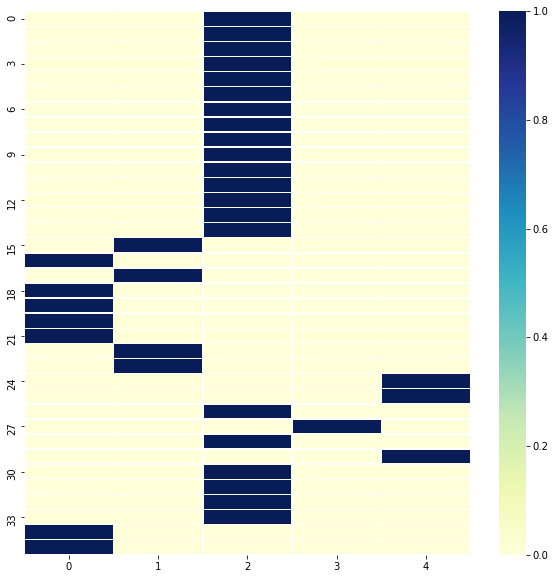

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=Toy_Optimal_Strategy_Per_Demo, linewidths=0.5, cmap="YlGnBu",ax=ax, yticklabels=3)


In [23]:
Demo_With_Strategy = summary_df[summary_df.columns[0:4]].copy()
Demo_With_Strategy["Bidding Strategy"] = Toy_Optimal_Strategy_Per_Demo_Name
Demo_With_Strategy

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,Bidding Strategy
0,unknown,1,1,M,Strategy 3
1,unknown,1,1,S,Strategy 3
2,unknown,1,2,M,Strategy 3
3,unknown,1,2,S,Strategy 3
4,unknown,2,1,M,Strategy 3
5,unknown,2,1,S,Strategy 3
6,unknown,2,2,M,Strategy 3
7,unknown,2,2,S,Strategy 3
8,unknown,3,1,M,Strategy 3
9,unknown,3,1,S,Strategy 3


### Maximize Policies Sold with Cost Constraint

In [64]:
minCperP = 10000000
toy2_optimal_cost = 0
Toy2_Optimal_Strategy_Per_Demo = np.zeros((36,5))
Toy2_Optimal_Strategy_Per_Demo_Name = ['' for x in range(0,36)]

Demos = range(0,36)
Strats = range(0,5)

for max_cost in range(5000,25000,500) :
    ToyModel2 = LpProblem("Maximum_Policies_Per_Cost",LpMaximize).copy()
    
    Variables_Toy2 = LpVariable.dicts("Vars",(Demos,Strats),cat="Binary")

    ToyModel2 += lpSum([[Policies[i,j]*Variables_Toy2[i][j] for j in Strats] for i in Demos])

    ToyModel2 += lpSum([[Cost[i,j]*Variables_Toy2[i][j] for j in Strats] for i in Demos]) <= max_cost

    for i in Demos:
        ToyModel2 += lpSum([Variables_Toy2[i][j] for j in Strats]) == 1
    
    status = ToyModel2.solve()
    #print("Status:",LpStatus[ToyModel2.status])

    Final_Strategy_Per_Demo = np.zeros((36,5))
    Final_Strategy_Per_Demo_Name = ['' for x in range(0,36)]
    Demo_Name = ['Rank 5','Decrease 1 Rank','Keep Same','Increase 1 Rank','Rank 1']
    for v in ToyModel2.variables() :
        if v.varValue > 0 :
            vsplit = v.name.split('_')
            i = int(vsplit[1])
            strat = int(vsplit[2])
            Final_Strategy_Per_Demo[i,strat] = 1        
            Final_Strategy_Per_Demo_Name[i] = Demo_Name[strat]
        
    if np.sum(Cost*Final_Strategy_Per_Demo)/np.sum(Policies*Final_Strategy_Per_Demo) < minCperP :
        minCperP = np.sum(Cost*Final_Strategy_Per_Demo)/np.sum(Policies*Final_Strategy_Per_Demo)
        toy2_optimal_cost = max_cost
        Toy2_Optimal_Strategy_Per_Demo = Final_Strategy_Per_Demo
        Toy2_Optimal_Strategy_Per_Demo_Name = Final_Strategy_Per_Demo_Name

In [66]:
print("Optimal Strategy that costs a maximum of",toy2_optimal_cost)
print("Policies Sold:",np.sum(Policies*Toy2_Optimal_Strategy_Per_Demo))
print("Total Cost:",np.sum(Cost*Toy2_Optimal_Strategy_Per_Demo))
print("Cost per Policy Sold",np.sum(Cost*Toy2_Optimal_Strategy_Per_Demo)/np.sum(Policies*Toy2_Optimal_Strategy_Per_Demo))

Optimal Strategy that costs a maximum of 5000
Policies Sold: 458.0
Total Cost: 4994.908140897751
Cost per Policy Sold 10.90591297139247


In [67]:
Demo_With_Strategy = summary_df[summary_df.columns[0:4]].copy()
Demo_With_Strategy["Strategy"] = Toy2_Optimal_Strategy_Per_Demo_Name
Demo_With_Strategy

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,Strategy
0,unknown,1,1,M,Decrease 1 Rank
1,unknown,1,1,S,Decrease 1 Rank
2,unknown,1,2,M,Decrease 1 Rank
3,unknown,1,2,S,Decrease 1 Rank
4,unknown,2,1,M,Decrease 1 Rank
5,unknown,2,1,S,Decrease 1 Rank
6,unknown,2,2,M,Decrease 1 Rank
7,unknown,2,2,S,Decrease 1 Rank
8,unknown,3,1,M,Decrease 1 Rank
9,unknown,3,1,S,Decrease 1 Rank
